# 감정 분석(Sentiment Analysis)

* 감정 분석은 텍스트에 등장하는 단어들을 통해 어떤 감정이 드러나는지 분석하는 기법
* 감정 분석은 오피니언 마이닝으로도 불리며, 텍스트에 담긴 의견, 태도 등을 알아보는데 유용한 기법
* 감정 분석을 하기 위해선 미리 정의된 감정 어휘 사전이 필요
* 감정 어휘 사전에 포함된 어휘가 텍스트에 얼마나 분포하는지에 따라 해당 텍스트의 감정이 좌우
* 토픽 모델링이 텍스트의 주제를 찾아낸다면, 감정 분석은 텍스트의 의견을 찾아냄
* 텍스트는 주제(토픽)와 의견(감정)의 결합으로 이루어졌다고 볼 수 있음

![2655364B5925AC9606[1].png](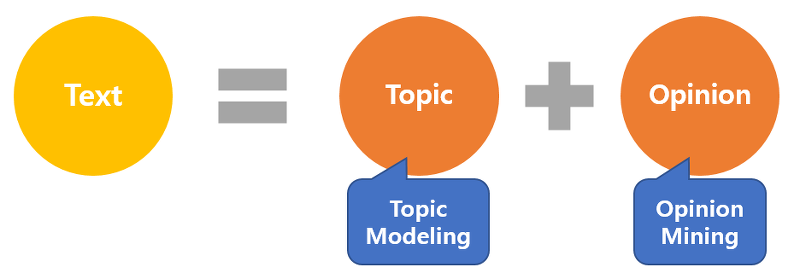)

* 감정 분석은 SNS, 리뷰 분석에 유용하게 사용할 수 있음
* 특정 이슈에 대한 사람들의 감정을 실시간으로 분석한다면, 그에 대해 신속하게 대처 가능

* 파이썬으로 감정 분석하는 방법은 크게 두 가지로 구분
  + `감정 어휘 사전`을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  + `기계학습`을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 라벨이 포함되어 있어야 하며,  
이를 인공 신경망, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

## 1.감정 어휘 사전을 이용한 감정 상태 분류

### 감정 사전 준비

*   `감정 사전 라이브러리`를 설치
*   `afinn`은 영어에 대한 긍정, 부정에 대한 감정 사전을 제공


### 데이터 준비

1.   사용할 데이터를 구성 
2.   데이터는 사이킷런에 내장되어 있는 `뉴스그룹 데이터`를 이용

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsdata = fetch_20newsgroups(subset='train')
newsdata.data[0]

C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 감정 상태 분류 및 시각화

*   감정 사전을 구성하고 감정 스코어를 측정
*   afinn 라이브러리는 감정 사전과 더불어 편리하게 감정가를 계산할 수 있는 함수를 제공

In [2]:
from afinn import Afinn

afinn = Afinn()
for i in range(10) :
    print(afinn.score(newsdata.data[i]))

7.0
11.0
16.0
5.0
-23.0
-25.0
7.0
3.0
16.0
-20.0


*   모든 뉴스에 대한 감정을 시각화
*   긍정과 부정에 대한 갯수를 시각화



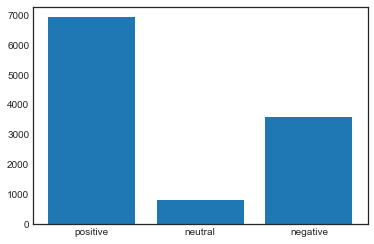

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

positive=0
neutral = 0
negative=0

for i in newsdata.data:
    score = afinn.score(i)
    if score > 0 :
        positive += 1
    elif score == 0:
        neutral += 1
    else :
        negative += 1
        
#전체 긍정/부정/neutral 개수가 나옴
plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()

## 2.기계학습을 이용한 감정 분석

#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [4]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 네이버 영화 리뷰 데이터

* 참고: https://wikidocs.net/44249

#### 데이터 로드

* 데이터를 웹에서 바로 받아오기 위해 `urllib.request` 사용
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
* 받아온 데이터를 `dataframe`으로 변환하고 데이터를 확인



In [5]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

In [6]:
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


#### 중복 및 결측치 처리

*   데이터 개수 확인
*   데이터에 중복이 존재한다면 이를 제거



In [7]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

146182
2


In [8]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any')

id          0
document    1
label       0
dtype: int64


#### 데이터 정제



*   데이터에서 한글과 공백을 제외하고 모두 제거



In [10]:
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [11]:
train_data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [12]:
#정규표현식으로 제거하고 난후 빈 데이터가 391이 되었음
train_data['document'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


In [13]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145791


In [14]:
#테스트 데이터도 똑같이 전처리
test_data.drop_duplicates(subset=['document'], inplace = True)
test_data['document']=test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print(len(test_data))

48995


C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 토큰화 및 불용어 제거



* 단어들을 분리하고 불용어를 제거함
* 불용어 사전: `'의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'`



In [15]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [16]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

X_train = []
for sentence in train_data['document'] :
    X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [17]:
X_train[:2]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']]

In [18]:
X_test = []
for sentence in test_data['document'] :
    X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#print(tokenizer.word_index)

#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [ ]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items() : #word_counts값을 dictionary로 받아옴
    words_freq = words_freq + value
    
    if value < threshold : #rare한거 개수셈
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print("전체 단어 수: " , words_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format(rare_cnt / words_cnt))
print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq/words_freq)*100 ))

In [ ]:
vocab_size = words_cnt - rare_cnt + 2 #2는 0번째 패딩, out of vocabulary token 넣어줘야해서 
print(vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) #seqeunce 형태로 변형
X_test = tokenizer.texts_to_sequences(X_test) 

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index,sentece in enumerate(X_train) if len(sentence) < 1] 
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(X_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

#### 패딩



*   리뷰의 전반적인 길이를 확인
*   모델의 입력을 위해 동일한 길이로 맞춰줌



In [ ]:
print("리뷰 최대 길이 :" , max(len(l) for l in X_train))
print('리뷰 평균 길이 :' , sum(map(len, X_train))/len(X_train))

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_len = 60

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### 모델 구축 및 학습

*   감정 상태 분류 모델을 선언하고 학습
*   모델은 일반적인 LSTM 모델을 사용

